# Segmentation ResNet18 in FastAI

> Training notebook for this architecture.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.dataloaders import *
from steel_segmentation.metrics import *
from steel_segmentation.trainer import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [3]:
fastai.__version__

'2.2.3'

In [4]:
torch.__version__

'1.7.1+cu101'

In [5]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [6]:
torch.cuda.empty_cache()

In [7]:
!nvidia-smi

Mon Mar  8 14:27:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   27C    P5     8W / 180W |      4MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
print_competition_data(models_dir)

../models/fastai-UNET-ResNet34-256-stage5.pth
../models/.ipynb_checkpoints
../models/kaggle-UNET-ResNet34.pth
../models/fastai-UNET-ResNet34-256-stage3.pth
../models/kaggle-FPN-ResNet34.pth


Training a Unet model with `xresnet18` encoder with progressive resizing.

In [9]:
arch = xresnet18

## Half-size: 128x800

In [10]:
# bs = 4 # 8 gb
bs = 16 # 16 gb
# bs = 32 # 24 gb
szs = (128, 800)

In [11]:
dls = get_segmentation_dls(bs, szs)

In [12]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

In [13]:
segmentation_learner.summary()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/metrics.py:376: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/storage/steel_segmentation/steel_segmentation/metrics.py:90: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


DynamicUnet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 64 x 400  
Conv2d                                    864        False     
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       False     
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 64 x 400  
Conv2d                                    18432      False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                              

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=3.0199516913853586e-05)

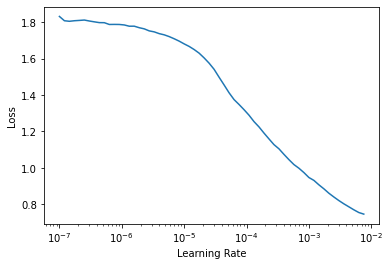

In [14]:
segmentation_learner.lr_find()

In [15]:
segmentation_learner.metrics.pop()
segmentation_learner.metrics

(#1) [<fastai.metrics.DiceMulti object at 0x7fcc99db47c0>]

In [16]:
segmentation_learner.fit_flat_cos(15, lr=4e-4)

epoch,train_loss,valid_loss,dice_multi,time
0,0.092942,0.087516,0.310726,10:09
1,0.084470,0.088898,0.297857,10:08
2,0.069326,0.068058,0.406197,10:07
3,0.067956,0.065904,0.428886,10:07
4,0.065091,0.064319,0.460326,10:07
5,0.059701,0.062830,0.411705,10:07
6,0.062317,0.061621,0.447182,10:07
7,0.059415,0.061167,0.498294,10:07
8,0.056137,0.066103,0.539902,10:07
9,0.058423,0.056513,0.560902,10:07


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (pos >= pcts).nonzero().max()


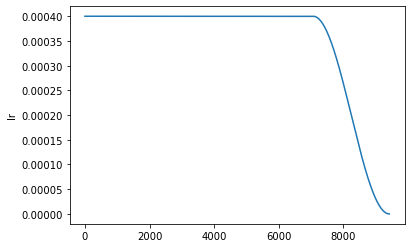

In [20]:
segmentation_learner.recorder.plot_sched()

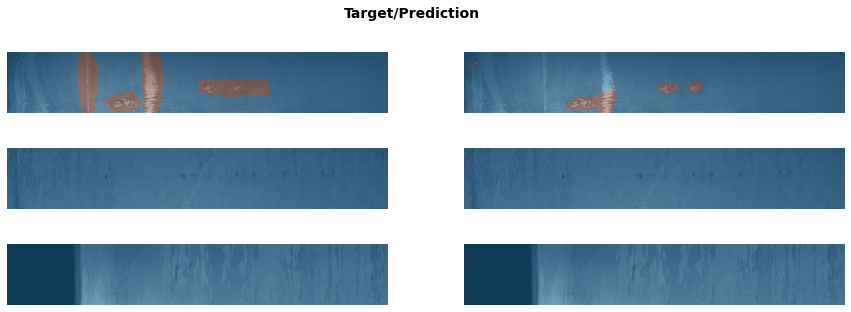

In [27]:
segmentation_learner.show_results(figsize=(15,5))

In [28]:
segmentation_learner.save("fastai-UNET-XResNet18")

Path('../models/fastai-UNET-XResNet18.pth')

In [29]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.5848931980144698e-06)

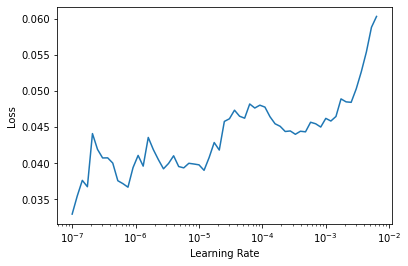

In [30]:
segmentation_learner.lr_find()

In [31]:
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,dice_multi,time
0,0.039021,0.048366,0.664042,10:23
1,0.042211,0.048055,0.667264,10:23
2,0.041970,0.047932,0.669157,10:23
3,0.044495,0.048043,0.660968,10:23


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
segmentation_learner.save("fastai-UNET-XResNet18-stage2")

Path('../models/fastai-UNET-XResNet18-stage2.pth')

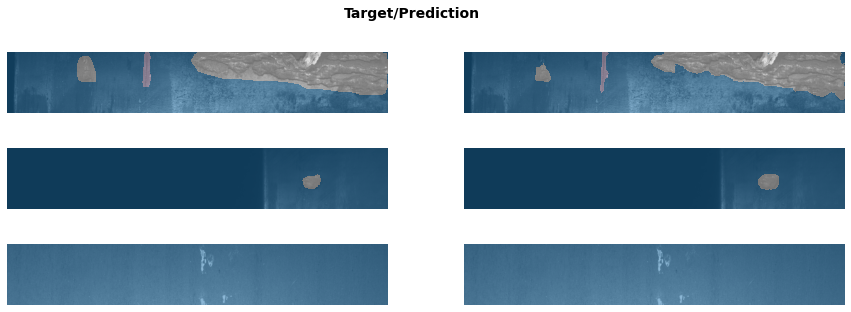

In [38]:
segmentation_learner.show_results(figsize=(15,5))

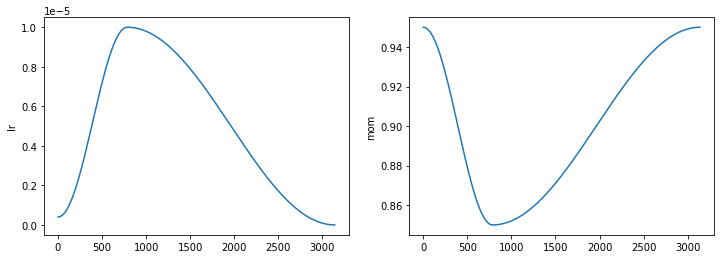

In [39]:
segmentation_learner.recorder.plot_sched()

### Training

In [ ]:
# Loading classifier weights
encoder_path = models_dir / "ResNet18-2_class.pt"

In [ ]:
segmentation_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

In [ ]:
# segmentation_learner.freeze()

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.4454397387453355e-05)

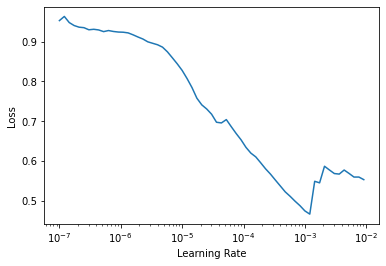

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
segmentation_learner.fit_one_cycle(10, lr_max=slice(1e-4, 7e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.077617,0.064304,0.400094,0.864774,07:18
1,0.073341,0.064050,0.395965,0.893417,07:17
2,0.068002,0.061350,0.531013,0.871681,07:14
3,0.055269,0.068252,0.472958,0.880891,07:13
4,0.054680,0.051352,0.545535,0.898572,07:13
5,0.050968,0.049561,0.571110,0.914313,07:12
6,0.048079,0.046953,0.564529,0.914444,07:12
7,0.044176,0.045532,0.641343,0.910027,07:12
8,0.042984,0.044673,0.666555,0.917361,07:12
9,0.039853,0.044556,0.673061,0.915163,07:12


In [ ]:
#segmentation_learner.save("ResNet18-Unet-128-stage1")

Path('models/ResNet18-Unet-stage1.pth')

In [ ]:
# stage2
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-4, 7e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.047727,0.050091,0.566619,0.915236,07:10
1,0.049110,0.051488,0.614058,0.889133,07:12
2,0.043920,0.045470,0.589829,0.918991,07:12
3,0.042332,0.043937,0.680346,0.920434,07:12
4,0.039790,0.042920,0.683014,0.923082,07:12


In [ ]:
#segmentation_learner.save("ResNet18-Unet-128-stage2")

Path('models/ResNet18-Unet-stage2.pth')

### Fine-tuning

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-128-stage2")

In [ ]:
segmentation_learner.validate()

(#3) [0.042923491448163986,0.6830139631164355,0.9230815172195435]

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=6.309573450380412e-07)

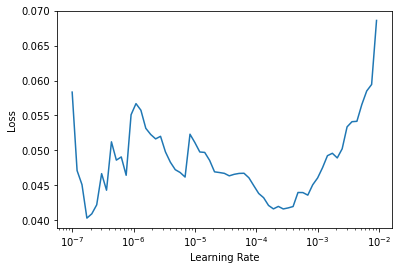

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage3
segmentation_learner.fit_one_cycle(10, lr_max=slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.042608,0.043629,0.685057,0.922095,10:06
1,0.043650,0.044138,0.688359,0.920928,10:05
2,0.042094,0.044083,0.694718,0.919718,10:05
3,0.038842,0.044115,0.684455,0.919441,10:05
4,0.040834,0.042209,0.695586,0.925560,10:06
5,0.038396,0.042617,0.703305,0.929716,10:06
6,0.035363,0.041282,0.713529,0.929295,10:05
7,0.032947,0.041631,0.719175,0.929696,10:05
8,0.034092,0.041418,0.724688,0.930014,10:05
9,0.034992,0.041048,0.727225,0.929578,10:05


In [ ]:
segmentation_learner.save("ResNet18-Unet-128-stage3")

Path('models/ResNet18-Unet-128-stage3.pth')

## Original-size: 256x1600

In [ ]:
bs = 2 # 8 gb
# bs = 4 # 16 gb
# bs = 8 # 24 gb

In [ ]:
dls = get_segmentation_dls(bs, (256, 1600))
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-128-stage3")

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=7.585775847473997e-07)

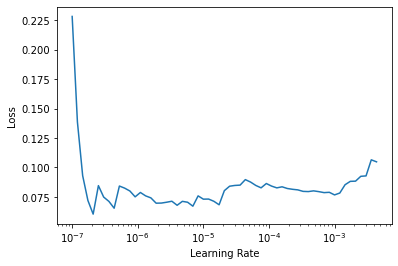

In [ ]:
segmentation_learner.lr_find()

In [ ]:
#stage1
segmentation_learner.fit_one_cycle(8, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.048108,0.048416,0.660539,0.897118,40:33
1,0.049675,0.046585,0.670772,0.908768,40:24
2,0.053268,0.048370,0.614278,0.904974,40:22
3,0.047116,0.046116,0.720387,0.905115,40:22
4,0.045527,0.048141,0.707756,0.905977,40:22
5,0.034245,0.051016,0.720741,0.910700,40:23
6,0.040398,0.046979,0.719904,0.917155,40:23
7,0.042392,0.046165,0.714892,0.914811,40:23


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage1")

Path('models/ResNet18-Unet-256-stage1.pth')

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage1")

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=2.75422871709452e-06)

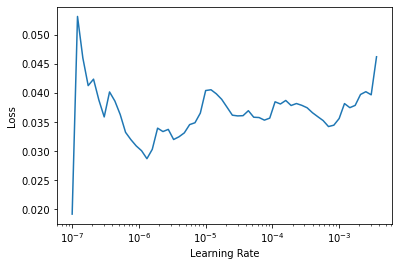

In [ ]:
segmentation_learner.lr_find()

In [ ]:
#stage2
segmentation_learner.fit_one_cycle(8, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.034535,0.045978,0.705646,0.922038,29:35
1,0.037973,0.048681,0.663536,0.926412,29:35
2,0.042783,0.043509,0.733397,0.916882,29:35
3,0.043034,0.043290,0.731311,0.918266,29:36


In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage2")

### Fine-tuning

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage2")

In [ ]:
segmentation_learner.validate()

(#3) [0.0431373193860054,0.729721425655278,0.9257643222808838]

In [ ]:
segmentation_learner.unfreeze()

In [ ]:
orig_dls = get_segmentation_dls(bs, (256, 1600), with_btfms=False)
segmentation_learner.dls = orig_dls

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=6.309573450380412e-07)

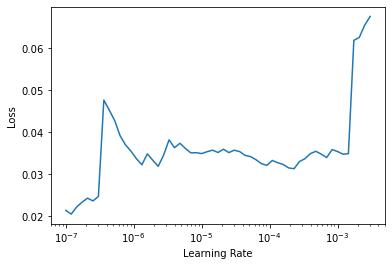

In [ ]:
segmentation_learner.lr_find()

In [ ]:
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.041420,0.044097,0.732492,0.902380,30:39
1,0.035430,0.043714,0.728829,0.921726,30:37
2,0.036363,0.041688,0.719019,0.923786,30:36
3,0.039209,0.041530,0.730980,0.927874,30:36
4,0.030240,0.042403,0.735394,0.926116,30:36


In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage3")

Path('models/ResNet18-Unet-256-stage3.pth')

## Results

In [ ]:
bs = 2 # 8 gb
# bs = 4 # 16 gb
# bs = 8 # 24 gb

In [ ]:
bs = 6 # 8 gb
# bs = 4 # 16 gb
# bs = 8 # 24 gb

In [ ]:
orig_dls = get_segmentation_dls(bs, (256, 1600), with_btfms=False)
segmentation_learner.dls = orig_dls

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage3")

In [ ]:
segmentation_learner.validate()

(#3) [0.387442409992218,0.21576465218699598,0.7342864274978638]

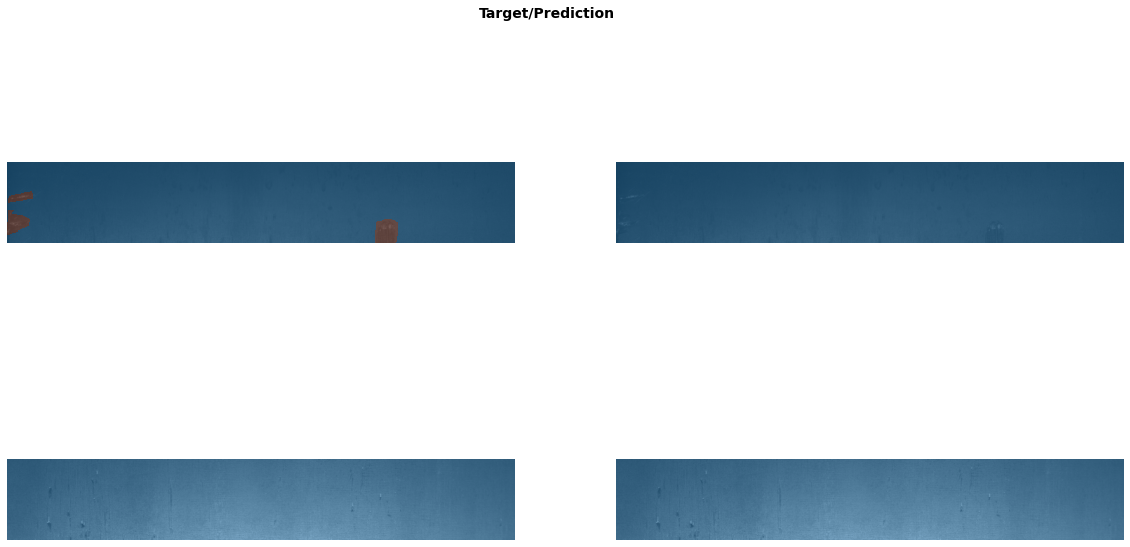

In [ ]:
segmentation_learner.show_results(figsize=(20,10))

## Predictions

*In italiano perché da sviluppare ancora*:

Per salvare gli output del modello è necessario:

1. fare inferenza sul validation set tramite il metodo `get_preds` (se si passa il parametro `with_decoded` permette di ottenere le probabilità invece dei digits).

2. Togliere i gradienti (se non è già stato fatto utilizzando `detach`) e convertire in un `np.array`.

3. Iterare su tutte le immagini, iterare per ogni immagine su ogni classe di difetto e utilizzare funzione `post_process` che filtra tutte le previsioni con pochi pixel data una certa soglia. 

4. Dalle maschere in `np.array` ottenute per ogni immagine, creare una codifica RLE utilizzando la funzione `mask2rle`.

5. Costruire il `pd.DataFrame` con le maschere codificate.

6. Costruire le maschere in formato `png` utilizzando la funzione `create_masks`.

In [ ]:
preds, targs = learn.get_preds() # dovrebbe di default lavorare sul validation set

In [ ]:
# si potrebbe fare sul test set attraverso il metodo DataLoaders.test_dl